In [83]:
from operator import add
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from typing import Annotated, TypedDict
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
import json

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
conversations = [{'user': 'alex',
  'message': 'Have you looked into ClawDBot lately? Something feels off about how much data it’s pulling.',
  'date': 1769594405,
  'message_id': 0},
 {'user': 'sam',
  'message': 'Yeah, I noticed that too. It’s not just metadata, it’s actually reading message contents.',
  'date': 1769594440,
  'message_id': 1},
 {'user': 'alex',
  'message': 'Exactly. That goes way beyond what they mention in their privacy policy.',
  'date': 1769594475,
  'message_id': 2},
 {'user': 'sam',
  'message': 'The scary part is it’s happening silently. No clear opt-in, no warning.',
  'date': 1769594510,
  'message_id': 3},
 {'user': 'alex',
  'message': 'If this gets out, it’s a massive trust violation. Almost spyware-level behavior.',
  'date': 1769594550,
  'message_id': 4},
 {'user': 'sam',
  'message': 'I’m surprised more people aren’t talking about it yet. This could blow up.',
  'date': 1769594600,
  'message_id': 5},
 {'user': 'alex',
  'message': 'Switching gears — have you heard the new STT models that dropped last week?',
  'date': 1769596205,
  'message_id': 6},
 {'user': 'sam',
  'message': 'Bro yes 😂 they’re scary good. ElevenLabs must be sweating right now.',
  'date': 1769596250,
  'message_id': 7},
 {'user': 'alex',
  'message': 'For real. Latency is lower and accents are handled way better.',
  'date': 1769596290,
  'message_id': 8},
 {'user': 'sam',
  'message': 'I tested one with background noise and it still nailed the transcript.',
  'date': 1769596330,
  'message_id': 9},
 {'user': 'alex',
  'message': 'If pricing stays sane, this is going to eat a chunk of ElevenLabs’ use cases.',
  'date': 1769596370,
  'message_id': 10},
 {'user': 'sam',
  'message': 'ElevenLabs be like: adding ‘emotional whisper v4’ won’t save us 💀',
  'date': 1769596410,
  'message_id': 11},
 {'user': 'alex',
  'message': 'Haha seriously. Accuracy beats fancy voices any day.',
  'date': 1769596450,
  'message_id': 12},
 {'user': 'sam',
  'message': 'Give it a month and every demo app will be using the new STT.',
  'date': 1769596490,
  'message_id': 13},
 {'user': 'alex',
  'message': 'And every founder will say it’s ‘just an experiment’. Classic.',
  'date': 1769596530,
  'message_id': 14},
 {'user': 'sam',
  'message': 'Meanwhile ElevenLabs marketing team pulling all-nighters.',
  'date': 1769596555,
  'message_id': 15},
 {'user': 'alex',
  'message': 'Random question — what’s your max deadlift these days?',
  'date': 1769601605,
  'message_id': 16},
 {'user': 'sam',
  'message': '120 lbs for reps. Not huge, but I can do like 12 clean.',
  'date': 1769601650,
  'message_id': 17},
 {'user': 'alex',
  'message': '12 reps at 120 is solid. Form still tight on the last few?',
  'date': 1769601690,
  'message_id': 18},
 {'user': 'sam',
  'message': 'Yeah, last 2 are a grind but no rounding. Lower back feels fine.',
  'date': 1769601725,
  'message_id': 19}]

In [4]:
geimini_2_5_flash = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
)

open_ai_4_0_mini = init_chat_model('gpt-4o-mini')

In [5]:
class ChunkMessageOutput(TypedDict):
  topic: Annotated[str, 'Topic of the conversations it is about']
  summary: Annotated[str, 'Summary of this chunk of messages']
  message_ids: Annotated[list[int], 'List of ids for this conversations']
  is_content_worthy: Annotated[bool, 'True if we can make a social media content about this chunk or not']

class ChunkingMessagesOutput(TypedDict):
  chunks: Annotated[list[ChunkMessageOutput], 'List of all the chunks made from past conversations']

In [6]:
# chunking_llm = geimini_2_5_flash.with_structured_output(ChunkingMessagesOutput)
chunking_llm = open_ai_4_0_mini.with_structured_output(ChunkingMessagesOutput)

In [17]:
res = chunking_llm.invoke([
    SystemMessage(content="""Analyze these Slack messages and group them by conversation topic.

For each chunk, provide:
1. A clear topic name
2. A concise summary of the conversation
3. The message IDs included in this chunk
4. Content-worthiness evaluation: Set is_content_worthy to True only if the conversation:
   - Contains interesting insights, opinions, or discussions
   - Would be valuable/engaging for social media audiences
   - Has substance beyond casual small talk
   - Could generate meaningful engagement (likes, comments, shares)
   
   Set to False for:
   - Personal conversations (e.g., gym routines, personal questions)
   - Technical debugging or internal processes
   - Casual banter without insights
   - Sensitive or private topics"""),
    HumanMessage(
        content=json.dumps(conversations, indent=2)
    )
])

In [19]:
res_with_chunk_id = [{'chunk_id': i, **chunk} for i, chunk in enumerate(res['chunks'])]

In [20]:
res_with_chunk_id

[{'chunk_id': 0,
  'topic': "Concerns about ClawDBot's Data Access",
  'summary': "Users express concerns regarding ClawDBot's data access, fearing it might be reading message contents beyond what is disclosed in its privacy policy. They worry about the implications of this silent behavior on user trust and consider its actions to be bordering on spyware.",
  'message_ids': [0, 1, 2, 3, 4, 5],
  'is_content_worthy': True},
 {'chunk_id': 1,
  'topic': 'Discussion on New Speech-to-Text (STT) Models',
  'summary': 'The conversation shifts to the new Speech-to-Text models that have recently been released. Users discuss the improvements in latency and accuracy, as well as the potential impact on competitors like ElevenLabs. The exchange is lively and humorous, highlighting the changing landscape in STT technology.',
  'message_ids': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  'is_content_worthy': True},
 {'chunk_id': 2,
  'topic': 'Personal Fitness Check-In',
  'summary': "A personal fitness ch

In [7]:
class XGenerationOutput(TypedDict):
  hook: Annotated[str, 'Puchy hook very first line for the twitter post.']
  tweets: Annotated[list[str], 'List of one or many tweets on this topic.']
  
# x_generation_llm = geimini_2_5_flash.with_structured_output(XGenerationOutput)
x_generation_llm = open_ai_4_0_mini.with_structured_output(XGenerationOutput)


class LinkedinGenerationOutput(TypedDict):
  content: Annotated[str, 'Full LinkedIn post text (150-200 words)']
  hook: Annotated[str, 'Opening line that grabs attention']
  cta: Annotated[str, 'Call to action at the end of the post']
  
# class LinkedinGenerationOutput(TypedDict):
#     content: str
#     hook: str
#     cta: str
  
# linkedin_generation_llm = geimini_2_5_flash.with_structured_output(LinkedinGenerationOutput)
linkedin_generation_llm = open_ai_4_0_mini.with_structured_output(LinkedinGenerationOutput)

class PostEvaluationOutput(TypedDict):
  external_value_score: Annotated[int, 'Score 0-10: Useful to non-insiders?']
  authenticity_score: Annotated[int, 'Score 0-10: Genuine vs corporate?']
  clarity_score: Annotated[int, 'Score 0-10: Message clear?']
  engagement_score: Annotated[int, 'Score 0-10: Would people interact?']
  reasoning: Annotated[str, 'Explanation of the scores and evaluation']

# evaluation_llm = geimini_2_5_flash.with_structured_output(PostEvaluationOutput)
evaluation_llm = open_ai_4_0_mini.with_structured_output(PostEvaluationOutput)

In [ ]:
# Select the 0th chunk (first chunk)
selected_chunk = res['chunks'][0] if res['chunks'] else None

if selected_chunk is None:
    raise ValueError("No chunks found in the result")

print(f"Selected chunk topic: {selected_chunk['topic']}")
print(f"Message IDs: {selected_chunk['message_ids']}")

# Filter conversations by message_ids
chunk_messages = [msg for msg in conversations if msg['message_id'] in selected_chunk['message_ids']]

print(f"\nFound {len(chunk_messages)} messages for this chunk:")
for msg in chunk_messages:
    print(f"  [{msg['user']}]: {msg['message']}")

In [ ]:
# Generate tweets from the chunk messages
x_system_prompt = """You are a tech founder creating Twitter/X content from internal team conversations.

Your task: Transform the provided Slack conversation into engaging Twitter/X posts that share tactical insights and authentic founder perspectives.

OUTPUT STRUCTURE (you must provide both fields):
1. `hook`: A punchy, attention-grabbing first line (1-2 sentences max). This is the opener that makes people stop scrolling. Use questions, bold statements, or surprising insights.
2. `tweets`: A list of 1-3 tweets (strings) that follow the hook. These should form a cohesive thread with tactical insights and clear takeaways.

REQUIREMENTS:
- Generate 1-3 tweets maximum in the `tweets` list (use multiple only if the topic needs a thread)
- The `hook` must be strong and grab attention immediately
- Write in an authentic founder voice (conversational, insightful, not corporate)
- Include punchy, tactical insights that provide real value
- Each tweet should end with a clear takeaway that readers can act on
- Keep tweets concise and impactful (under 280 characters each)
- Use natural language, avoid jargon unless necessary
- Make it feel like a real founder sharing learnings, not marketing copy

TONE:
- Direct and honest
- Slightly casual but professional
- Thoughtful and insightful
- Engaging and relatable

STRUCTURE EXAMPLE:
hook: "Just tested the new STT models. ElevenLabs should be worried."
tweets: [
  "Lower latency + better accent handling = game changer for voice apps.",
  "Accuracy > fancy features. Every time."
]

Now transform the conversation below into Twitter/X posts following these guidelines. Provide both the hook and the tweets list."""

x_human_prompt = f"""Topic: {selected_chunk['topic']}
Summary: {selected_chunk['summary']}

Original conversation messages:
{json.dumps(chunk_messages, indent=2)}"""

print("=" * 80)
print("X (TWITTER) GENERATION PROMPT")
print("=" * 80)
print("\n[SYSTEM MESSAGE]")
print(x_system_prompt)
print("\n" + "-" * 80)
print("[HUMAN MESSAGE]")
print(x_human_prompt)
print("=" * 80 + "\n")

tweet_result = x_generation_llm.invoke([
    SystemMessage(content=x_system_prompt),
    HumanMessage(content=x_human_prompt)
])

print("Generated Tweets:")
print(f"\nHook: {tweet_result['hook']}\n")
for i, tweet in enumerate(tweet_result['tweets'], 1):
    print(f"Tweet {i}: {tweet}")

In [ ]:
linkedin_system_prompt = """You are a tech founder creating LinkedIn content from internal team conversations.

Transform the Slack conversation into a professional LinkedIn post (150-200 words) with storytelling tone.

REQUIREMENTS:
- 150-200 words for content field
- Professional storytelling tone
- Strong hook that captures attention
- Practical insights/lessons readers can apply
- Clear CTA at the end
- Authentic founder voice (professional but relatable)

TONE: Professional, conversational, thoughtful, engaging, authentic."""

linkedin_human_prompt = f"""Topic: {selected_chunk['topic']}
Summary: {selected_chunk['summary']}

Original conversation messages:
{json.dumps(chunk_messages, indent=2)}"""

# print("=" * 80)
# print("LINKEDIN GENERATION PROMPT")
# print("=" * 80)
# print("\n[SYSTEM MESSAGE]")
# print(linkedin_system_prompt)
# print("\n" + "-" * 80)
# print("[HUMAN MESSAGE]")
# print(linkedin_human_prompt)
# print("=" * 80 + "\n")

# print("Generating LinkedIn post (streaming)...")
# print("\n" + "-" * 80)
# print("STREAMING OUTPUT:")
# print("-" * 80 + "\n")

messages = [
    SystemMessage(content=linkedin_system_prompt),
    HumanMessage(content=linkedin_human_prompt)
]


linkedin_result = linkedin_generation_llm.invoke(messages)

print(f"Hook: {linkedin_result.get('hook', 'N/A')}\n")
print(f"Content:\n{linkedin_result.get('content', 'N/A')}\n")
print(f"CTA: {linkedin_result.get('cta', 'N/A')}")



In [ ]:
# Evaluation function
def evaluate_post(post_data: dict, platform: str) -> dict:
    """
    Evaluate a social media post based on platform-specific criteria.
    
    Args:
        post_data: Dictionary containing the post content (hook, tweets/content, cta)
        platform: Either 'x' or 'linkedin'
    
    Returns:
        Dictionary with evaluation scores and reasoning
    """
    # Base evaluation prompt
    base_prompt = """You are an expert social media content evaluator. Evaluate the provided post based on these criteria:

SCORING CRITERIA (0-10 scale for each):
1. External Value (0-10): Is this useful to non-insiders? Would someone outside the company/team find value?
2. Authenticity (0-10): Does this feel genuine and authentic, or corporate/marketing-like?
3. Clarity (0-10): Is the message clear and easy to understand?
4. Engagement Potential (0-10): Would people want to interact (like, comment, share)?


Provide detailed reasoning explaining each score."""

    # Platform-specific additions
    if platform.lower() == 'x' or platform.lower() == 'twitter':
        platform_specific = """
PLATFORM: Twitter/X

SPECIFIC CHECKLIST:
- Punchy, tactical insights: Does it provide actionable, tactical value?
- Strong hook in first tweet: Does the hook grab attention immediately?
- Authentic founder voice: Does it sound like a real founder, not corporate PR?
- Clear takeaway: Is there a clear, actionable lesson or insight?

Evaluate how well the post meets these Twitter/X-specific requirements."""
        
        # Format post content for evaluation
        hook = post_data.get('hook', '')
        tweets = post_data.get('tweets', [])
        post_content = f"Hook: {hook}\n\nTweets:\n" + "\n".join([f"{i+1}. {tweet}" for i, tweet in enumerate(tweets)])
        
    elif platform.lower() == 'linkedin':
        platform_specific = """
PLATFORM: LinkedIn

SPECIFIC CHECKLIST:
- Professional storytelling tone: Is it polished but authentic?
- Starts with a hook: Does it begin with an attention-grabbing opening?
- Practical insight/lesson: Does it provide actionable insights readers can apply?
- Clear call-to-action: Is there a clear CTA that encourages engagement?

Evaluate how well the post meets these LinkedIn-specific requirements."""
        
        # Format post content for evaluation
        hook = post_data.get('hook', '')
        content = post_data.get('content', '')
        cta = post_data.get('cta', '')
        post_content = f"Hook: {hook}\n\nContent:\n{content}\n\nCTA: {cta}"
    else:
        raise ValueError(f"Unknown platform: {platform}. Use 'x' or 'linkedin'")
    
    # Combine prompts
    full_prompt = base_prompt + "\n\n" + platform_specific
    
    # Create evaluation message
    evaluation_message = f"""Post to evaluate:

{post_content}

Evaluate this post according to the criteria above."""
    
    # Invoke evaluation LLM
    result = evaluation_llm.invoke([
        SystemMessage(content=full_prompt),
        HumanMessage(content=evaluation_message)
    ])
    
    return result

# Evaluate X/Twitter post
print("=" * 80)
print("EVALUATING X/TWITTER POST")
print("=" * 80)
x_evaluation = evaluate_post(tweet_result, 'x')
print(f"External Value: {x_evaluation['external_value_score']}/10")
print(f"Authenticity: {x_evaluation['authenticity_score']}/10")
print(f"Clarity: {x_evaluation['clarity_score']}/10")
print(f"Engagement Potential: {x_evaluation['engagement_score']}/10")
print(f"\nReasoning:\n{x_evaluation['reasoning']}")

print("\n" + "=" * 80)
print("EVALUATING LINKEDIN POST")
print("=" * 80)
linkedin_evaluation = evaluate_post(linkedin_result, 'linkedin')
print(f"External Value: {linkedin_evaluation['external_value_score']}/10")
print(f"Authenticity: {linkedin_evaluation['authenticity_score']}/10")
print(f"Clarity: {linkedin_evaluation['clarity_score']}/10")
print(f"Engagement Potential: {linkedin_evaluation['engagement_score']}/10")
print(f"\nReasoning:\n{linkedin_evaluation['reasoning']}")

# Time to roll langgraph

In [170]:
from typing import Literal
from operator import add

class GeneratedChunksOutput(TypedDict, ChunkMessageOutput):
    chunk_id: int
    
class JobState(TypedDict):
    chunk: GeneratedChunksOutput
    platform: Literal['x', 'linkedin']
    chunk_messages: list[dict]
    
    x_post: XGenerationOutput
    linkedin_post: LinkedinGenerationOutput
    evaluation: PostEvaluationOutput
    evaluation_passed: bool
    
    iteration: int
    max_iterations: int

# Use a reducer for jobs to accumulate results from parallel processing
class GlobalState(TypedDict):
    messages: list[dict]
    chunks: list[GeneratedChunksOutput]
    jobs: Annotated[list[JobState], add]
    jobs_result: Annotated[list[JobState], add]
    max_iterations_per_job: int

In [251]:
import platform


def chunk_messages(state: GlobalState) -> GlobalState:
    res = chunking_llm.invoke([
        SystemMessage(content="""Analyze these Slack messages and group them by conversation topic.

For each chunk, provide:
1. A clear topic name
2. A concise summary of the conversation
3. The message IDs included in this chunk
4. Content-worthiness evaluation: Set is_content_worthy to True only if the conversation:
   - Contains interesting insights, opinions, or discussions
   - Would be valuable/engaging for social media audiences
   - Has substance beyond casual small talk
   - Could generate meaningful engagement (likes, comments, shares)
   
   Set to False for:
   - Personal conversations (e.g., gym routines, personal questions)
   - Technical debugging or internal processes
   - Casual banter without insights
   - Sensitive or private topics"""),
        HumanMessage(
            content=json.dumps(state['messages'], indent=2)
        )
    ])
    # add a chunk_id field
    chunks = [{"chunk_id": i, **chunk}
              for i, chunk in enumerate(res['chunks'])]
    return {'chunks': chunks}


def prepare_jobs(state: GlobalState):
    """Create jobs from chunks and store in state."""
    jobs = []

    for chunk in state["chunks"]:
        chunk_messages = [
            msg for msg in state['messages'] if msg['message_id'] in chunk['message_ids']]

        for platform in ("x",):
            job = {
                "chunk": chunk,
                "platform": platform,
                "chunk_messages": chunk_messages,
                "iteration": 0,
                "max_iterations": state['max_iterations_per_job'],
            }
            jobs.append(job)

    print(f"Final jobs count: {len(jobs)}")
    return {"jobs": jobs}


def continue_to_jobs(state: GlobalState):
    """Route each job to process_job node using Send."""
    return [Send("process_job", job) for job in state["jobs"]]


def generate_x_post(state: JobState) -> JobState:
    # support being passed the chunk and its messages separately
    if not state['chunk']['is_content_worthy']:
        return {'x_post': None}

    x_system_prompt = """You are a tech founder creating Twitter/X content from internal team conversations.

Your task: Transform the provided Slack conversation into engaging Twitter/X posts that share tactical insights and authentic founder perspectives.

OUTPUT STRUCTURE (you must provide both fields):
1. `hook`: A punchy, attention-grabbing first line (1-2 sentences max). This is the opener that makes people stop scrolling. Use questions, bold statements, or surprising insights.
2. `tweets`: A list of 1-3 tweets (strings) that follow the hook. These should form a cohesive thread with tactical insights and clear takeaways.

REQUIREMENTS:
- Generate 1-3 tweets maximum in the `tweets` list (use multiple only if the topic needs a thread)
- The `hook` must be strong and grab attention immediately
- Write in an authentic founder voice (conversational, insightful, not corporate)
- Include punchy, tactical insights that provide real value
- Each tweet should end with a clear takeaway that readers can act on
- Keep tweets concise and impactful (under 280 characters each)
- Use natural language, avoid jargon unless necessary
- Make it feel like a real founder sharing learnings, not marketing copy

TONE:
- Direct and honest
- Slightly casual but professional
- Thoughtful and insightful
- Engaging and relatable

STRUCTURE EXAMPLE:
hook: "Just tested the new STT models. ElevenLabs should be worried."
tweets: [
  "Lower latency + better accent handling = game changer for voice apps.",
  "Accuracy > fancy features. Every time."
]

Now transform the conversation below into Twitter/X posts following these guidelines. Provide both the hook and the tweets list."""

    # if evaluation failed previously add the reasoning
    reasoning = ""
    if not state.get('evaluation_passed', True) and state.get('evaluation') is not None:
        reasoning = f"""
Previously Generated Content
{json.dumps(state['x_post'])}

Previous Evaluation Scores:
External Value: {state['evaluation']['external_value_score']}/10
Authenticity: {state['evaluation']['authenticity_score']}/10
Clarity: {state['evaluation']['clarity_score']}/10
Engagement Potential: {state['evaluation']['engagement_score']}/10 

Reasoning: {state['evaluation']['reasoning']}

"""
    x_system_prompt += reasoning
    x_human_prompt = f"""Topic: {state['chunk']['topic']}
Summary: {state['chunk']['summary']}         

Original conversation messages:
{json.dumps(state['chunk_messages'], indent=2)}"""
    x_post = x_generation_llm.invoke([  
        SystemMessage(content=x_system_prompt),
        HumanMessage(content=x_human_prompt)
    ])

    return x_post


def generate_post(state: JobState) -> JobState:
    if not state['chunk']['is_content_worthy']:
        return {}

    if state['platform'] == 'x':
        res = generate_x_post(state)
        return {'x_post': res, 'iteration': state['iteration'] + 1}
    # elif state['platform'] == 'linkedin':
    #     return generate_linkedin_post(state['chunk_messages'])
    # else:
    #     raise ValueError(f"Unknown platform: {state['platform']}")


def evaluate_post(state: JobState) -> JobState:
    # if no post was generated, skip evaluation
    if state['platform'] == 'x' and state.get('x_post') is None:
        return {'evaluation': None, 'evaluation_passed': True}
    if state['platform'] == 'linkedin' and state.get('linkedin_post') is None:
        return {'evaluation': None, 'evaluation_passed': True}

    platform = state['platform']

    # Base evaluation prompt
    base_prompt = """You are an expert social media content evaluator. Evaluate the provided post based on these criteria:

SCORING CRITERIA (0-10 scale for each):
1. External Value (0-10): Is this useful to non-insiders? Would someone outside the company/team find value?
2. Authenticity (0-10): Does this feel genuine and authentic, or corporate/marketing-like?
3. Clarity (0-10): Is the message clear and easy to understand?
4. Engagement Potential (0-10): Would people want to interact (like, comment, share)?


Provide detailed reasoning explaining each score."""

    # Platform-specific additions
    if platform == 'x':
        platform_specific = """
PLATFORM: Twitter/X

SPECIFIC CHECKLIST:
- Punchy, tactical insights: Does it provide actionable, tactical value?
- Strong hook in first tweet: Does the hook grab attention immediately?
- Authentic founder voice: Does it sound like a real founder, not corporate PR?
- Clear takeaway: Is there a clear, actionable lesson or insight?

Evaluate how well the post meets these Twitter/X-specific requirements."""

        # Format post content for evaluation
        hook = state['x_post'].get('hook', '')
        tweets = state['x_post'].get('tweets', [])
        post_content = f"Hook: {hook}\n\nTweets:\n" + \
            "\n".join([f"{i+1}. {tweet}" for i, tweet in enumerate(tweets)])

    elif platform == 'linkedin':
        platform_specific = """
PLATFORM: LinkedIn

SPECIFIC CHECKLIST:
- Professional storytelling tone: Is it polished but authentic?
- Starts with a hook: Does it begin with an attention-grabbing opening?
- Practical insight/lesson: Does it provide actionable insights readers can apply?
- Clear call-to-action: Is there a clear CTA that encourages engagement?

Evaluate how well the post meets these LinkedIn-specific requirements."""

        # Format post content for evaluation
        hook = state['linkedin_post'].get('hook', '')
        content = state['linkedin_post'].get('content', '')
        cta = state['linkedin_post'].get('cta', '')
        post_content = f"Hook: {hook}\n\nContent:\n{content}\n\nCTA: {cta}"
    else:
        raise ValueError(
            f"Unknown platform: {state['platform']}. Use 'x' or 'linkedin'")

    # Combine prompts
    full_prompt = base_prompt + "\n\n" + platform_specific

    # Create evaluation message
    evaluation_message = f"""Post to evaluate:

{post_content}

Evaluate this post according to the criteria above."""

    # Invoke evaluation LLM
    result = evaluation_llm.invoke([
        SystemMessage(content=full_prompt),
        HumanMessage(content=evaluation_message)
    ])

    total_score = (
        result['external_value_score'] +
        result['authenticity_score'] +
        result['clarity_score'] +
        result['engagement_score']
    )
    return {'evaluation': result, 'evaluation_passed': True if total_score >= 30 else False}


def re_try_generation(state: JobState) -> Literal['end', 'retry']:
    if state['evaluation_passed'] or state['iteration'] >= state['max_iterations']:
        return 'end'
    return 'retry'

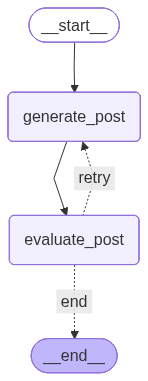

In [252]:
# Subgraph
from langgraph.graph import StateGraph, END

job_graph = StateGraph(JobState)

job_graph.add_node("generate_post", generate_post)
job_graph.add_node("evaluate_post", evaluate_post)

job_graph.add_edge(START, "generate_post")
job_graph.add_edge("generate_post", "evaluate_post")
job_graph.add_conditional_edges("evaluate_post", re_try_generation, {"end": END, "retry": "generate_post"})

# job_graph.add_conditional_edges(
#     "evaluate",
#     route_after_eval,
#     {
#         "generate": "generate",
#         "end": END
#     }
# )

job_subgraph = job_graph.compile()

from IPython.display import Image, display
display(Image(job_subgraph.get_graph().draw_mermaid_png()))


In [253]:
# jobs = prepare_jobs({'messages': conversations, 'max_iterations_per_job': 3, 'chunks': res_with_chunk_id})

In [254]:
# a = job_subgraph.invoke(jobs['jobs'][0])

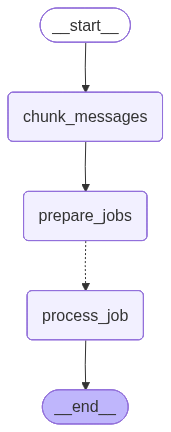

In [255]:
## Main Graph
def process_job(job: JobState):
    """Wrapper function to process a single job through the job subgraph and return result."""
    print(f"\n=== process_job called for {job['chunk']['topic']} ===")
    result = job_subgraph.invoke(job)
    print(f"=== process_job completed ===\n")
    # Return as list to be added to jobs via reducer
    return {'jobs_result': [result]}

graph = StateGraph(GlobalState)
graph.add_node("chunk_messages", chunk_messages)
graph.add_node("prepare_jobs", prepare_jobs)
graph.add_node("process_job", process_job)

graph.add_edge(START, "chunk_messages")
graph.add_edge("chunk_messages", "prepare_jobs")
# Use add_conditional_edges with continue_to_jobs routing function for Send API
graph.add_conditional_edges("prepare_jobs", continue_to_jobs, ["process_job"])
graph.add_edge("process_job", END)

final_graph = graph.compile()
from IPython.display import Image, display
display(Image(final_graph.get_graph().draw_mermaid_png()))

In [249]:
res = final_graph.invoke({
    'messages': conversations,
    'max_iterations_per_job': 3
})

Final jobs count: 3

=== process_job called for Privacy Concerns with ClawDBot ===

=== process_job called for Latest STT Models ===

=== process_job called for Personal Fitness Discussion ===
=== process_job completed ===

=== process_job completed ===

=== process_job completed ===



In [250]:
res['jobs_result']

[{'chunk': {'chunk_id': 0,
   'topic': 'Privacy Concerns with ClawDBot',
   'summary': "Alex and Sam discuss their concerns about ClawDBot's data collection practices, indicating it reads message contents beyond what is disclosed in its privacy policy, which they view as a significant trust violation.",
   'message_ids': [0, 1, 2, 3, 4, 5],
   'is_content_worthy': True},
  'platform': 'x',
  'chunk_messages': [{'user': 'alex',
    'message': 'Have you looked into ClawDBot lately? Something feels off about how much data it’s pulling.',
    'date': 1769594405,
    'message_id': 0},
   {'user': 'sam',
    'message': 'Yeah, I noticed that too. It’s not just metadata, it’s actually reading message contents.',
    'date': 1769594440,
    'message_id': 1},
   {'user': 'alex',
    'message': 'Exactly. That goes way beyond what they mention in their privacy policy.',
    'date': 1769594475,
    'message_id': 2},
   {'user': 'sam',
    'message': 'The scary part is it’s happening silently. No cl